### Librerias

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import os
from numpy.testing import assert_allclose
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#import tensorflow_addons as tfa
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.preprocessing import image
from keras.models import Model
from keras import backend as K
import warnings
warnings.filterwarnings("ignore")

### Carga y procesamiento de imagenes

In [2]:
%%time
#Lista de categorías
directorio = os.path.join(os.getcwd(), "F:/sonidos aves/data_sliding_short/")
categorias = os.listdir(directorio)

#Listas de imagenes y etiquetas del modelo
imagenes = []
etiquetas = []

#Construcción de las listas
for i in range(len(categorias)):
    cat = os.listdir(directorio+"/"+categorias[i])
    for j in range(len(cat)):
        img = cv2.imread(directorio+"/"+categorias[i]+"/"+cat[j])
        #resized = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hist = cv2.equalizeHist(gray)
        imagenes.append(hist)
        etiquetas.append(categorias.index(categorias[i]))
    print("Imagenes de la categoria " + categorias[i] + " cargadas!")
        
#Listas convertidas en variables
X = np.array(imagenes, dtype=np.uint8)         
y = np.array(etiquetas)

Imagenes de la categoria Ammodramus humeralis_Grassland Sparrow cargadas!
Imagenes de la categoria Ara severus_Chestnut-fronted Macaw cargadas!
Imagenes de la categoria Aramus guarauna_Limpkin cargadas!
Imagenes de la categoria Bubo virginianus_Great Horned Owl cargadas!
Imagenes de la categoria Bubulcus ibis_Cattle Egret cargadas!
Imagenes de la categoria Buteo nitidus_Gray-lined Hawk cargadas!
Imagenes de la categoria Buteo platypterus_Broad-winged Hawk cargadas!
Imagenes de la categoria Campephilus melanoleucos_Crimson-crested Woodpecker cargadas!
Imagenes de la categoria Camptostoma obsoletum_Southern Beardless-Tyrannulet cargadas!
Imagenes de la categoria Catharus ustulatus_Swainson_s Thrush cargadas!
Imagenes de la categoria Chloroceryle amazona_Amazon Kingfisher cargadas!
Imagenes de la categoria Chlorophonia cyanea_Blue-naped Chlorophonia cargadas!
Imagenes de la categoria Chondrohierax uncinatus_Hook-billed Kite cargadas!
Imagenes de la categoria Chordeiles minor_Common Nighth

### conjuntos de entrenamiento y prueba

In [3]:
%%time

Xtrain, Xtest, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(Xtrain.shape)
print(Xtest.shape)

(55009, 224, 224)
(13753, 224, 224)
CPU times: total: 906 ms
Wall time: 896 ms


### Redimensionamiento y escalado de imagenes

In [ ]:
%%time
num_classes = 96
input_shape = (224, 224, 1)

#normalizando los datos
train_scaled =np.zeros(Xtrain.shape[:3], dtype= "float32")
for i in range(Xtrain.shape[0]):
    train_scaled[i]=Xtrain[i]/255
    
test_scaled =np.zeros(Xtest.shape[:3], dtype= "float32")
for i in range(Xtest.shape[0]):
    test_scaled[i]=Xtest[i]/255
    
#Redimensionando
X_train = train_scaled.reshape(train_scaled.shape[0], train_scaled.shape[1], train_scaled.shape[2], 1)
X_test = test_scaled.reshape(test_scaled.shape[0], test_scaled.shape[1], test_scaled.shape[2], 1)
print(X_train.shape)
print(X_test.shape)

#Redimensionando vectores
y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)
print(y_train.shape)
print(y_test.shape)

### Paràmetro de la red

In [5]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 100
image_size = 224  # We'll resize input images to this size
patch_size = 112  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 64
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [5000, 5000] 

### Perceptron multicapa

In [6]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implementación del Patch

In [7]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

### Visualización de los parches

Image size: 224 X 224
Patch size: 112 X 112
Patches per image: 4
Elements per patch: 12544


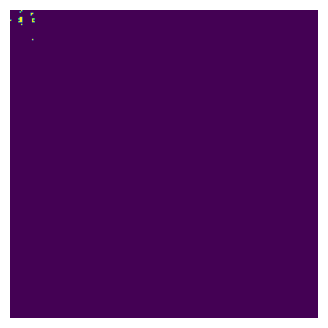

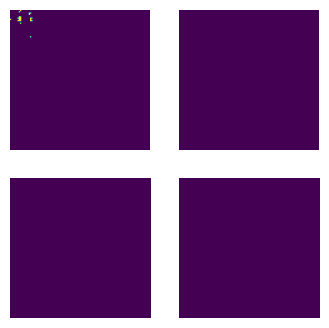

In [8]:
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

### Implementacion de la capa patch encoding

In [9]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

### Construcción del VIT Model

In [10]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.2
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.2)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.9)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.9)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

modelo = create_vit_classifier()
print(modelo.summary())
keras.utils.plot_model(modelo, show_shapes=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ patches_1 (Patches)           │ (None, None, 12544)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ patch_encoder (PatchEncoder)  │ (None, 4, 64)             │         803,136 │ patches_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 4, 64)             │             128 │ patch_encoder[0][0]        │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention          │ (None, 4, 64)             │       1,060,928 │ layer_normalization[0][0], │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 4, 64)             │               0 │ multi_head_attention[0][0… │
│                               │                           │                 │ patch_encoder[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_1         │ (None, 4, 64)             │             128 │ add[0][0]                  │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 4, 128)            │           8,320 │ layer_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 4, 128)            │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 4, 64)             │           8,256 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 4, 64)             │               0 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 4, 64)             │               0 │ dropout_2[0][0], add[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_2         │ (None, 4, 64)             │             128 │ add_1[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_1        │ (None, 4, 64)             │       1,060,928 │ layer_normalization_2[0][… │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 36,195,440 (138.07 MB)

 Trainable params: 36,195,440 (138.07 MB)

 Non-trainable params: 0 (0.00 B)

None
You must install pydot (`pip install pydot`) for `plot_model` to work.


### Compilacion y uso de la red Vit Transformer

In [20]:
new_model = modelo.load_weights("F:/sonidos aves/checkpoint.weights.h5")

directorio = os.path.join(os.getcwd(), "F:/sonidos aves/prueba concepto/espectrogramas")
categoria_esp = os.listdir(directorio)

imagen = []
categoria = []
prediccion = []
probabilidad = []

for i in range(len(categoria_esp)):
    cat = os.listdir(directorio+"/"+categoria_esp[i])
    for j in range(len(cat)):
        img = cv2.imread(directorio+"/"+categoria_esp[i]+"/"+cat[j])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hist = cv2.equalizeHist(gray)
        #resized = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)
        img_norm = hist/255
        resized = img_norm.reshape(1, 224, 224, 1)
        logits = modelo.predict(resized)
        probabilities = np.exp(logits) / np.sum(np.exp(logits))
        predict = categorias[np.argmax(probabilities[0])]
        prob = np.max(probabilities[0])    
        imagen.append(cat[j])
        prediccion.append(predict)
        probabilidad.append(prob)
        categoria.append(categoria_esp[i])
    
    
#Generando el dataframe final
data = {"imagen": imagen, "categoria": categoria, 'prediccion': prediccion, "Probabilidad": probabilidad}
df = pd.DataFrame(data=data)
df.to_excel("F:/sonidos aves/prueba_concepto2.xlsx")
df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

,imagen,categoria,prediccion,Probabilidad
0,Dysithamnus mentalis_Plain Antvireo_SMU04082_2...,Dysithamnus mentalis_Plain Antvireo,Dendrocygna autumnalis_Black-bellied Whistling...,0.537579
1,Dysithamnus mentalis_Plain Antvireo_SMU04082_2...,Dysithamnus mentalis_Plain Antvireo,Dysithamnus mentalis_Plain Antvireo,0.333642
2,Dysithamnus mentalis_Plain Antvireo_SMU04082_2...,Dysithamnus mentalis_Plain Antvireo,Ammodramus humeralis_Grassland Sparrow,0.243313
3,Dysithamnus mentalis_Plain Antvireo_SMU04082_2...,Dysithamnus mentalis_Plain Antvireo,Sicalis flaveola_Saffron Finch,0.742892
4,Dysithamnus mentalis_Plain Antvireo_SMU04082_2...,Dysithamnus mentalis_Plain Antvireo,Sicalis flaveola_Saffron Finch,0.521645
...,...,...,...,...
1336,Tyrannus melancholicus_Tropical Kingbird_SMU04...,Tyrannus melancholicus_Tropical Kingbird,Sicalis flaveola_Saffron Finch,0.809138
1337,Tyrannus melancholicus_Tropical Kingbird_SMU04...,Tyrannus melancholicus_Tropical Kingbird,Sicalis flaveola_Saffron Finch,0.779279
1338,Xenops rutilans_Streaked Xenops_SMU04082_20240...,Xenops rutilans_Streaked Xenops,Gampsonyx swainsonii_Pearl Kite,0.819327
1339,Xenops rutilans_Streaked Xenops_SMU04082_20240...,Xenops rutilans_Streaked Xenops,Gampsonyx swainsonii_Pearl Kite,0.741160
